In [360]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import natsort
import re
#We gebruiken de from ... import voor commando's die we veel gebruiken om repititie te verminderen 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from zipfile import ZipFile
import tensorflow as tf

UPLOAD EERST DE DATA ZIP in COLAB, ANDERS KAN HET VOLGENDE BLOK CODE DEZE NIET UITPAKKEN

In [361]:
standaarddirectory = os.getcwd()                  #standaarddirectory van google colab opslaan zodat we altijd terug kunnen keren naar deze
file_name = "delay_dataset.zip"                   
if not os.path.exists("stud_train"):              #Als de data nog niet uitgepakt is en deze folder dus nog niet bestaat, gaan we dit doen
  with ZipFile(file_name,'r') as zipper:
    zipper.extractall()
    print("extractie data klaar")

if not os.path.exists("stud_train_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_ASDR")
if not os.path.exists("stud_train_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_GAUSS")
if not os.path.exists("stud_train_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_SBOX")

if not os.path.exists("stud_test_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_ASDR")
if not os.path.exists("stud_test_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_GAUSS")
if not os.path.exists("stud_test_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_SBOX")

In [362]:
# variable declaration
train_set = 'stud_train'
test_set = 'stud_test'
delaypiekASDR = []    #array met actuele delays tussen de pieken (validatiecijfers voor training)
delaypiekGAUSS = []
delaypiekSBOX = []
delaypiekASDRtest = []    #array met actuele delays tussen de pieken (cijfers voor testing)
delaypiekGAUSStest = []
delaypiekSBOXtest = []

In [363]:
#Geeft een array met strings weer waarin de namen van de files in die map staan
def laadarraymetfilenamenuitmap(map):
    filenames = os.listdir(map)  # array met alle filenames van in folder
    filenames.sort()
    return filenames

In [364]:
#plot het signaal van een numpy array aan de hand van een megegeven signaalbestandsnaam
#Functie werd enkel gebruikt in het begin, niet meer relevant op het einde
def plotsignaal(signaal, evencheck, nummer, x = np.arange(0,512)): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:
        kleur = "red"         #paar van signalen respectievelijk rood en blauw weergeven zodat het verschil duidelijk is
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(x,np.load(signaal), color=kleur)

In [365]:
#Geeft de waarde van de positie van die piek terug aan de hand van de bestandsnaam
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) 
  return piek

In [366]:
#voegt de array van twee signalen samen om 1 vector van 1024 samples te bekomen
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

In [367]:
#wordt gebruikt om de lijst met de files te sorten op numerische orde ipv alfabetische orde om sortering van 0 1 10 11 ... 19 2 20 21 ... 29 3 30 31 etc te voorkomen maar 0 1 2 3 4 ... 99
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [368]:
def combinedata(folder, dir, delayarray, typesignaal = "", testoftrain = "", aantalgrafiekenplotten = 0):
  i = 0
  nummer = 1
  evencheck = 0
  x = np.arange(0, 1024)
  k = 0
  for data in folder:
    evencheck += 1
    if k != 0 and evencheck % 2 == 0:
      os.chdir(f"stud_{testoftrain}")
      masterfile = voegsamen(previous, data)
      os.chdir(standaarddirectory)

      os.chdir(dir)
      savename = f"{nummer}{typesignaal}.npy"
      np.save(savename,masterfile)
      os.chdir(standaarddirectory)
      nummer += 1
      delayarray.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))

      #plotten voor eerste paar grafieken, mooie visualisatie als controle
      if evencheck < ((aantalgrafiekenplotten*2)+1):  #evencheck > aantal grafieken*2, max 41 vanwege memory limiet -> 20 grafieken, zet op 1 indien je geen grafieken wil zien
        plot= plt.figure(nummer)
        plt.plot(x,masterfile, color="red")

    k += 1
    previous = data

END OF FUNCTIONS

In [369]:
#main
#filenames inlezen
filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:200]
filenamesGAUSS = filenames[200:400]
filenamesSBOX = filenames[400:600]

filenamestest = laadarraymetfilenamenuitmap(test_set)
filenamesASDRtest = filenamestest[0:200]
filenamesGAUSStest = filenamestest[200:400]
filenamesSBOXtest = filenamestest[400:600]

#sorteren
filenamesASDR.sort(key=natural_keys)
filenamesGAUSS.sort(key=natural_keys)
filenamesSBOX.sort(key=natural_keys)
filenamesASDRtest.sort(key=natural_keys)
filenamesGAUSStest.sort(key=natural_keys)
filenamesSBOXtest.sort(key=natural_keys)

In [370]:
os.chdir(standaarddirectory)
combinedata(filenamesASDR, "stud_train_combined_ASDR", delaypiekASDR, "ASDR", "train")
combinedata(filenamesGAUSS, "stud_train_combined_GAUSS", delaypiekGAUSS, "GAUSS", "train")
combinedata(filenamesSBOX, "stud_train_combined_SBOX", delaypiekSBOX, "SBOX", "train")

combinedata(filenamesASDRtest, "stud_test_combined_ASDR", delaypiekASDRtest, "ASDR", "test")
combinedata(filenamesGAUSStest, "stud_test_combined_GAUSS", delaypiekGAUSStest, "GAUSS", "test")
combinedata(filenamesSBOXtest, "stud_test_combined_SBOX", delaypiekSBOXtest, "SBOX", "test")

In [371]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_ASDR")

samplesASDR = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDR = tf.convert_to_tensor(samplesASDR)

os.chdir(standaarddirectory)

In [372]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_ASDR")

samplesASDRtest = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDRtest = tf.convert_to_tensor(samplesASDRtest)

os.chdir(standaarddirectory)

In [373]:
#TENSOR object maken voor y waarden NN training
delayASDR = pd.DataFrame(data = delaypiekASDR)
delayASDR = tf.convert_to_tensor(delayASDR)

In [374]:
#Model aanmaken
modelASDR = tf.keras.Sequential()
modelASDR.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelASDR.add(layers.Dense(256, activation='relu'))
modelASDR.add(layers.Dense(64, activation='relu'))
modelASDR.add(layers.Dense(8, activation='relu'))
modelASDR.add(layers.Dense(1))

In [375]:
modelASDR.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 512)               524800    
                                                                 
 dense_106 (Dense)           (None, 256)               131328    
                                                                 
 dense_107 (Dense)           (None, 64)                16448     
                                                                 
 dense_108 (Dense)           (None, 8)                 520       
                                                                 
 dense_109 (Dense)           (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [376]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelASDR.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [377]:
#Model Trainen
history = modelASDR.fit(samplesASDR,
                        delayASDR,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 9ms/step - loss: 574.9371 - mae: 574.9371
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 565.7422 - mae: 565.7422
Epoch 3/20
4/4 [==============================] - 0s 12ms/step - loss: 540.0396 - mae: 540.0396
Epoch 4/20
4/4 [==============================] - 0s 10ms/step - loss: 481.6812 - mae: 481.6812
Epoch 5/20
4/4 [==============================] - 0s 11ms/step - loss: 366.3318 - mae: 366.3318
Epoch 6/20
4/4 [==============================] - 0s 10ms/step - loss: 161.3068 - mae: 161.3068
Epoch 7/20
4/4 [==============================] - 0s 14ms/step - loss: 128.1584 - mae: 128.1584
Epoch 8/20
4/4 [==============================] - 0s 10ms/step - loss: 116.2189 - mae: 116.2189
Epoch 9/20
4/4 [==============================] - 0s 9ms/step - loss: 81.5922 - mae: 81.5922
Epoch 10/20
4/4 [==============================] - 0s 9ms/step - loss: 89.6994 - mae: 89.6994
Epoch 11/20
4/4 [==============================

In [378]:
predictionsASDR = modelASDR.predict(samplesASDRtest)

4/4 [==============================] - 0s 5ms/step


[87, 19, 98, 46, 27, 82, 117, 48, 8, 84, 73, 83, 25, 144, 17, 192, 143, 20, 42, 81, 31, 223, 59, 129, 7, 46, 105, 147, 143, 31, 1, 20, 64, 48, 65, 38, 65, 73, 60, 168, 4, 33, 1, 27, 85, 43, 3, 20, 51, 64, 57, 76, 127, 14, 164, 25, 41, 20, 139, 9, 22, 122, 88, 59, 26, 103, 57, 140, 11, 64, 142, 93, 65, 185, 77, 53, 101, 45, 82, 3, 166, 114, 15, 54, 72, 74, 140, 41, 91, 11, 13, 0, 141, 200, 171, 132, 43, 172, 166, 61]
[509.5400695800781, 624.7196655273438, 454.00128173828125, 644.86181640625, 585.6664428710938, 477.5569763183594, 680.4172973632812, 591.3922119140625, 551.7420043945312, 457.62109375, 538.4945068359375, 651.305419921875, 546.2371826171875, 430.09747314453125, 573.5986328125, 734.0704956054688, 464.16961669921875, 526.7826538085938, 545.0625610351562, 656.81787109375, 558.1192626953125, 375.7589111328125, 666.551513671875, 468.9176940917969, 540.8992309570312, 500.6028137207031, 506.7199401855469, 712.3071899414062, 691.9216918945312, 579.6793823242188, 547.0984497070312, 5

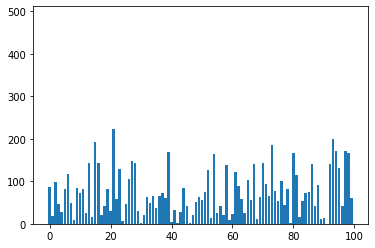

In [379]:
predictionslistASDR = predictionsASDR.tolist()
predictionslistASDRflat = [item for sublist in predictionslistASDR for item in sublist]

error_list_ASDR = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistASDRflat, delaypiekASDRtest):
  error_list_ASDR.append(round(abs(error1 - error2)))

print(error_list_ASDR)
print(predictionslistASDRflat)
print(delaypiekASDRtest)
#visualiseren error
bar = plt.figure(1)
plt.bar(np.arange(0, 100), error_list_ASDR)
plt.ylim(0, 512)
plt.show()


GAUSS MODEL

In [380]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_GAUSS")

samplesGAUSS = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSS = tf.convert_to_tensor(samplesGAUSS)

os.chdir(standaarddirectory)

In [381]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_GAUSS")

samplesGAUSStest = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSStest = tf.convert_to_tensor(samplesGAUSStest)

os.chdir(standaarddirectory)

In [382]:
#TENSOR object maken voor y waarden NN training
delayGAUSS = pd.DataFrame(data = delaypiekGAUSS)
delayGAUSS = tf.convert_to_tensor(delayGAUSS)

In [383]:
#Model aanmaken
modelGAUSS = tf.keras.Sequential()
modelGAUSS.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelGAUSS.add(layers.Dense(256, activation='relu'))
modelGAUSS.add(layers.Dense(64, activation='relu'))
modelGAUSS.add(layers.Dense(8, activation='relu'))
modelGAUSS.add(layers.Dense(1))

In [384]:
modelGAUSS.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 512)               524800    
                                                                 
 dense_111 (Dense)           (None, 256)               131328    
                                                                 
 dense_112 (Dense)           (None, 64)                16448     
                                                                 
 dense_113 (Dense)           (None, 8)                 520       
                                                                 
 dense_114 (Dense)           (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [385]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelGAUSS.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [386]:
#Model Trainen
history = modelGAUSS.fit(samplesGAUSS,
                        delayGAUSS,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 10ms/step - loss: 565.4249 - mae: 565.4249
Epoch 2/20
4/4 [==============================] - 0s 8ms/step - loss: 480.3312 - mae: 480.3312
Epoch 3/20
4/4 [==============================] - 0s 11ms/step - loss: 271.4009 - mae: 271.4009
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 104.0809 - mae: 104.0809
Epoch 5/20
4/4 [==============================] - 0s 8ms/step - loss: 63.4489 - mae: 63.4489
Epoch 6/20
4/4 [==============================] - 0s 10ms/step - loss: 89.6031 - mae: 89.6031
Epoch 7/20
4/4 [==============================] - 0s 9ms/step - loss: 36.3302 - mae: 36.3302
Epoch 8/20
4/4 [==============================] - 0s 9ms/step - loss: 38.0989 - mae: 38.0989
Epoch 9/20
4/4 [==============================] - 0s 9ms/step - loss: 39.1388 - mae: 39.1388
Epoch 10/20
4/4 [==============================] - 0s 9ms/step - loss: 22.0433 - mae: 22.0433
Epoch 11/20
4/4 [==============================] - 0s 12ms

In [387]:
predictionsGAUSS = modelGAUSS.predict(samplesGAUSStest)

4/4 [==============================] - 0s 7ms/step


[16, 18, 6, 6, 27, 7, 10, 5, 5, 10, 11, 9, 37, 25, 3, 24, 30, 13, 15, 18, 23, 11, 20, 15, 9, 7, 18, 19, 7, 9, 2, 9, 25, 15, 1, 19, 1, 48, 24, 7, 14, 8, 7, 7, 21, 44, 19, 120, 664, 3, 11, 6, 0, 14, 196, 18, 23, 5, 11, 2, 8, 42, 20, 7, 21, 1, 7, 39, 18, 21, 11, 2, 11, 6, 14, 5, 14, 26, 4, 33, 4, 23, 17, 19, 14, 0, 12, 20, 6, 4, 24, 18, 24, 12, 18, 26, 12, 23, 27, 29]
[568.1083374023438, 570.8570556640625, 559.0695190429688, 598.0624389648438, 581.0650024414062, 548.7289428710938, 586.8784790039062, 548.7272338867188, 606.2266845703125, 575.6484985351562, 567.924072265625, 583.7679443359375, 552.1736450195312, 579.8160400390625, 601.6441040039062, 563.714599609375, 617.2263793945312, 535.0584106445312, 539.7271118164062, 591.4986572265625, 580.5487670898438, 594.2007446289062, 542.53515625, 573.8104858398438, 549.2227172851562, 553.9972534179688, 582.631591796875, 587.28564453125, 613.714599609375, 546.3976440429688, 543.0530395507812, 574.7383422851562, 578.8165283203125, 573.64349365234

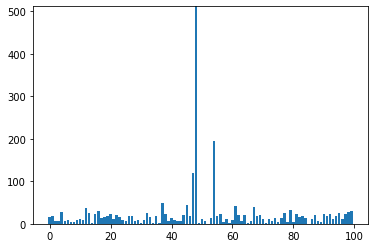

In [388]:
predictionslistGAUSS = predictionsGAUSS.tolist()
predictionslistGAUSSflat = [item for sublist in predictionslistGAUSS for item in sublist]

error_list_GAUSS = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistGAUSSflat, delaypiekGAUSStest):
  error_list_GAUSS.append(round(abs(error1 - error2)))

print(error_list_GAUSS)
print(predictionslistGAUSSflat)
print(delaypiekGAUSStest)
#visualiseren error
bar = plt.figure(2)
plt.bar(np.arange(0, 100), error_list_GAUSS)
plt.ylim(0, 512)
plt.show()


SBOX MODEL

In [389]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_SBOX")

samplesSBOX = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOX = tf.convert_to_tensor(samplesSBOX)

os.chdir(standaarddirectory)

In [390]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_SBOX")

samplesSBOXtest = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOXtest = tf.convert_to_tensor(samplesSBOXtest)

os.chdir(standaarddirectory)

In [391]:
#TENSOR object maken voor y waarden NN training
delaySBOX = pd.DataFrame(data = delaypiekSBOX)
delaySBOX = tf.convert_to_tensor(delaySBOX)

In [392]:
#Model aanmaken
modelSBOX = tf.keras.Sequential()
modelSBOX.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelSBOX.add(layers.Dense(256, activation='relu'))
modelSBOX.add(layers.Dense(64, activation='relu'))
modelSBOX.add(layers.Dense(8, activation='relu'))
modelSBOX.add(layers.Dense(1))

In [393]:
modelSBOX.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 512)               524800    
                                                                 
 dense_116 (Dense)           (None, 256)               131328    
                                                                 
 dense_117 (Dense)           (None, 64)                16448     
                                                                 
 dense_118 (Dense)           (None, 8)                 520       
                                                                 
 dense_119 (Dense)           (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [394]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelSBOX.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [395]:
#Model Trainen
history = modelSBOX.fit(samplesSBOX,
                        delaySBOX,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 10ms/step - loss: 578.0696 - mae: 578.0696
Epoch 2/20
4/4 [==============================] - 0s 9ms/step - loss: 557.6661 - mae: 557.6661
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 512.0267 - mae: 512.0267
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 421.5537 - mae: 421.5537
Epoch 5/20
4/4 [==============================] - 0s 10ms/step - loss: 258.9716 - mae: 258.9716
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 93.0896 - mae: 93.0896
Epoch 7/20
4/4 [==============================] - 0s 10ms/step - loss: 154.2305 - mae: 154.2305
Epoch 8/20
4/4 [==============================] - 0s 10ms/step - loss: 76.2035 - mae: 76.2035
Epoch 9/20
4/4 [==============================] - 0s 12ms/step - loss: 99.5789 - mae: 99.5789
Epoch 10/20
4/4 [==============================] - 0s 10ms/step - loss: 79.9101 - mae: 79.9101
Epoch 11/20
4/4 [==============================] - 

In [396]:
predictionsSBOX = modelSBOX.predict(samplesSBOXtest)

4/4 [==============================] - 0s 6ms/step


[60, 115, 9, 19, 96, 123, 88, 11, 69, 4, 90, 12, 40, 48, 31, 31, 71, 39, 62, 21, 63, 76, 27, 25, 59, 96, 2, 24, 45, 36, 22, 46, 40, 53, 36, 60, 51, 66, 0, 32, 77, 57, 23, 82, 8, 20, 11, 51, 39, 37, 36, 18, 56, 19, 14, 80, 117, 19, 62, 54, 23, 43, 1, 19, 59, 21, 23, 34, 51, 29, 12, 31, 22, 49, 31, 40, 33, 58, 9, 38, 19, 23, 14, 16, 48, 6, 40, 82, 81, 40, 62, 81, 4, 29, 44, 19, 18, 42, 63, 22]
[643.2989501953125, 660.284423828125, 576.9232177734375, 528.6259155273438, 655.787353515625, 672.052001953125, 661.2498168945312, 567.1636962890625, 627.2059326171875, 578.700927734375, 675.8505859375, 599.4248657226562, 597.9109497070312, 614.7896728515625, 560.3397216796875, 565.2444458007812, 613.0521850585938, 535.8675537109375, 620.4473876953125, 570.09228515625, 544.6740112304688, 627.8284301757812, 579.3487548828125, 569.3568115234375, 626.8822021484375, 643.368408203125, 596.8932495117188, 556.1529541015625, 564.8482055664062, 528.34375, 565.3228759765625, 500.35797119140625, 591.836120605

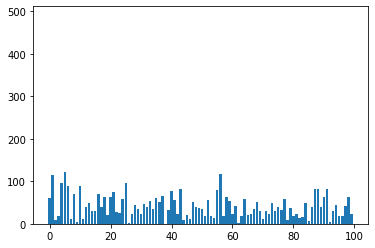

In [397]:
predictionslistSBOX = predictionsSBOX.tolist()
predictionslistSBOXflat = [item for sublist in predictionslistSBOX for item in sublist]

error_list_SBOX = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistSBOXflat, delaypiekSBOXtest):
  error_list_SBOX.append(round(abs(error1 - error2)))

print(error_list_SBOX)
print(predictionslistSBOXflat)
print(delaypiekSBOXtest)
#visualiseren error
bar = plt.figure(3)
plt.bar(np.arange(0, 100), error_list_SBOX)
plt.ylim(0, 512)
plt.show()


MODEL VOOR ALLE DRIE DE SIGNALEN

In [398]:
#TENSOR VAN 300X1024
samplestotal = tf.concat([samplesASDR, tf.concat([samplesGAUSS, samplesSBOX], axis=0)], axis=0)
samplestotaltest = tf.concat([samplesASDRtest, tf.concat([samplesGAUSStest, samplesSBOXtest], axis=0)], axis=0)
delaytotal = tf.concat([delayASDR, tf.concat([delayGAUSS, delaySBOX], axis=0)], axis=0)


In [399]:
#Model aanmaken
modeltotal = tf.keras.Sequential()
modeltotal.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modeltotal.add(layers.Dense(256, activation='relu'))
modeltotal.add(layers.Dense(64, activation='relu'))
modeltotal.add(layers.Dense(8, activation='relu'))
modeltotal.add(layers.Dense(1))

In [400]:
modeltotal.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 512)               524800    
                                                                 
 dense_121 (Dense)           (None, 256)               131328    
                                                                 
 dense_122 (Dense)           (None, 64)                16448     
                                                                 
 dense_123 (Dense)           (None, 8)                 520       
                                                                 
 dense_124 (Dense)           (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [401]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modeltotal.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [402]:
#Model Trainen
history = modelSBOX.fit(samplestotal,
                        delaytotal,
                        epochs=50)

Epoch 1/50
10/10 [==============================] - 0s 9ms/step - loss: 404.5321 - mae: 404.5321
Epoch 2/50
10/10 [==============================] - 0s 9ms/step - loss: 318.8999 - mae: 318.8999
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 296.3754 - mae: 296.3754
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 284.9212 - mae: 284.9212
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 289.4141 - mae: 289.4141
Epoch 6/50
10/10 [==============================] - 0s 9ms/step - loss: 275.8939 - mae: 275.8939
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 273.7841 - mae: 273.7841
Epoch 8/50
10/10 [==============================] - 0s 9ms/step - loss: 262.7238 - mae: 262.7238
Epoch 9/50
10/10 [==============================] - 0s 10ms/step - loss: 255.5040 - mae: 255.5040
Epoch 10/50
10/10 [==============================] - 0s 9ms/step - loss: 239.8831 - mae: 239.8831
Epoch 11/50
10/10 [======

In [403]:
predictionstotal = modeltotal.predict(samplestotaltest)

10/10 [==============================] - 0s 4ms/step


[597, 606, 552, 599, 559, 560, 563, 543, 560, 542, 611, 568, 571, 574, 557, 542, 607, 547, 587, 576, 589, 599, 608, 598, 548, 547, 612, 565, 549, 549, 546, 580, 545, 580, 552, 612, 571, 554, 581, 611, 601, 557, 556, 609, 583, 590, 598, 553, 555, 599, 559, 599, 577, 570, 586, 587, 563, 575, 597, 544, 568, 582, 542, 558, 552, 583, 567, 596, 547, 593, 592, 608, 560, 548, 562, 608, 559, 593, 562, 569, 608, 556, 564, 551, 583, 569, 553, 589, 604, 568, 558, 593, 559, 588, 599, 606, 574, 588, 564, 600, 550, 588, 552, 602, 554, 555, 596, 553, 609, 585, 577, 573, 588, 604, 603, 586, 585, 546, 554, 608, 603, 604, 562, 557, 557, 545, 600, 604, 606, 553, 543, 564, 603, 556, 581, 608, 595, 609, 607, 574, 590, 571, 593, 598, 598, 603, 556, 559, 547, 596, 543, 558, 604, 572, 601, 589, 595, 579, 549, 578, 598, 594, 569, 570, 564, 603, 587, 605, 595, 589, 591, 544, 558, 554, 579, 548, 563, 604, 595, 604, 605, 565, 548, 594, 589, 557, 608, 543, 540, 576, 542, 554, 610, 569, 585, 603, 547, 578, 593, 570,

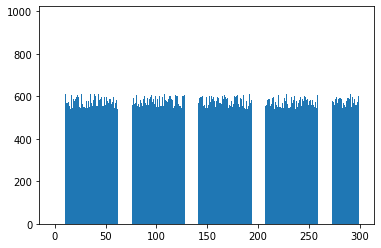

In [404]:
predictionslisttotal = predictionstotal.tolist()
predictionslisttotalflat = [item for sublist in predictionslisttotal for item in sublist]

delaypiektotaltest = delaypiekASDRtest + delaypiekGAUSStest + delaypiekSBOXtest

error_list_total = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslisttotalflat, delaypiektotaltest):
  error_list_total.append(round(abs(error1 - error2)))

print(error_list_total)
print(predictionslisttotalflat)
print(delaypiektotaltest)
#visualiseren error
bar = plt.figure(4)
plt.bar(np.arange(0, 300), error_list_total)
plt.ylim(0, 1024)
plt.show()




https://stackoverflow.com/questions/59737875/keras-change-learning-rate 